EVALUATION OF CNN models:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import random
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from skimage import segmentation
from torchvision import transforms
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats

data if needed:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = 'drive/MyDrive/MT/archive/Training'
test_dir = 'drive/MyDrive/MT/archive/Testing'

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    #transforms.TrivialAugmentWide(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                           std=[0.1768, 0.1768, 0.1768])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                           std=[0.1768, 0.1768, 0.1768])
])

In [ ]:
#Class weights: {0: 4.323996971990916, 1: 4.265870052277819, 2: 3.581191222570533, 3: 3.9203843514070007}

# Calculate class weights
train_counts = {
    0: 1321,  # Glioma
    1: 1339,  # Meningioma
    2: 1595,  # No Tumor
    3: 1457   # Pituitary
}

total_samples = sum(train_counts.values())  # 5712
class_weights = {class_idx: total_samples / count
                for class_idx, count in train_counts.items()}

print("Class weights:", class_weights)


Class weights: {0: 4.323996971990916, 1: 4.265870052277819, 2: 3.581191222570533, 3: 3.9203843514070007}


In [ ]:
# Training dataset with augmentation
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

# Validation dataset without augmentation
full_dataset = datasets.ImageFolder(train_dir, transform=val_test_transform)

# Testing dataset
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

In [ ]:
# Split train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# <a id='load'>Model:</a>

In [ ]:
class BrainCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def train_and_validate(model, train_loader, val_loader, test_loader, class_weights=None, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Calculate class weights if not provided
    if class_weights is None:
        class_weights = calculate_class_weights(train_loader)

    # Convert class weights to tensor
    weight_tensor = torch.FloatTensor([class_weights[i] for i in range(len(class_weights))]).to(device)

    # Initialize weighted loss function
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss/len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss/len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%')

    # Final Test Phase
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    print('\nFinal Test Results:')
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test Accuracy: {100 * test_correct / test_total:.2f}%')

    return history, model

# <a id='load'>Loading Models:</a>

In [ ]:
def load_model_from_checkpoint(checkpoint_path, model_class):
    """
    Load a model from a checkpoint file.

    Args:
        checkpoint_path (str): Path to the checkpoint file
        model_class (nn.Module): The model class to instantiate

    Returns:
        tuple: (loaded_model, history)
    """
    # Load the full checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Initialize model
    model = model_class()

    # Load the model state dict
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        history = checkpoint.get('history', None)
    else:
        # If the checkpoint is just the state dict
        model.load_state_dict(checkpoint)
        history = None

    # Set model to evaluation mode
    model.eval()

    return model, history

# Load all three models
model_paths = {
    'base': 'drive/MyDrive/results/archive21/base_model.pth',
    'trivial_aug': 'drive/MyDrive/results/archive21/TA_model_3.pth',
    'gans': 'drive/MyDrive/results/archive21/gan_model_2.pth',
    'combined': 'drive/MyDrive/results/archive21/combined_model_2.pth'
}

models = {}
histories = {}

for model_name, path in model_paths.items():
    try:
        model, history = load_model_from_checkpoint(path, BrainCNN)
        models[model_name] = model
        histories[model_name] = history
        print(f"Successfully loaded {model_name} model")
    except Exception as e:
        print(f"Error loading {model_name} model: {str(e)}")

<ipython-input-19-e1b7da3716d2>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_

Successfully loaded base model
Successfully loaded trivial_aug model
Successfully loaded gans model
Successfully loaded combined model


In [ ]:
base_model = models['base']
ta_model = models['trivial_aug']
gan_model = models['gans']
combined_model = models['combined']

# <a id='load'>Evaluation:</a>

In [ ]:
def evaluate_model(model, data_loader, device='cuda'):
    """
    Evaluate model on given data loader and return predictions and true labels

    Args:
        model: PyTorch model
        data_loader: DataLoader containing validation/test data
        device: Device to run evaluation on

    Returns:
        tuple: (predictions, true_labels)
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Get predicted class (argmax for multiclass)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

def calculate_metrics(predictions, true_labels):
    """
    Calculate multiple classification metrics for multiclass

    Args:
        predictions: Model predictions (numpy array)
        true_labels: True labels (numpy array)

    Returns:
        dict: Dictionary containing all metrics
    """
    metrics = {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, average='macro', zero_division=0),
        'recall': recall_score(true_labels, predictions, average='macro', zero_division=0),
        'f1': f1_score(true_labels, predictions, average='macro', zero_division=0)
    }

    # Add per-class metrics
    for metric_name in ['precision', 'recall', 'f1']:
        class_scores = eval(f"{metric_name}_score")(
            true_labels,
            predictions,
            average=None,
            zero_division=0
        )
        for i, score in enumerate(class_scores):
            metrics[f'{metric_name}_class_{i}'] = score

    return metrics

def compare_models(models, test_loader, device='cuda'):
    """
    Compare multiple models using various metrics

    Args:
        models: Dictionary of models to compare
        test_loader: DataLoader containing test data
        device: Device to run evaluation on

    Returns:
        dict: Dictionary containing metrics for all models
    """
    results = {}

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        predictions, true_labels = evaluate_model(model, test_loader, device)
        metrics = calculate_metrics(predictions, true_labels)
        results[model_name] = metrics

        print(f"{model_name} Results:")
        # Print overall metrics
        print("\nOverall Metrics:")
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            print(f"{metric}: {metrics[metric]:.4f}")

        # Print per-class metrics
        print("\nPer-class Metrics:")
        for i in range(4):  # for 4 classes
            print(f"\nClass {i}:")
            for metric in ['precision', 'recall', 'f1']:
                print(f"{metric}: {metrics[f'{metric}_class_{i}']:.4f}")

    return results

# Example usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate all models
results = compare_models(models, test_loader, device)

# Create a comparison table
import pandas as pd

# Create two DataFrames: one for overall metrics and one for per-class metrics
def create_comparison_tables(results):
    # Overall metrics
    overall_metrics = ['accuracy', 'precision', 'recall', 'f1']
    overall_df = pd.DataFrame({
        model_name: {metric: values[metric]
                    for metric in overall_metrics}
        for model_name, values in results.items()
    }).round(4)

    # Per-class metrics
    class_metrics = []
    for i in range(4):
        for metric in ['precision', 'recall', 'f1']:
            class_metrics.append(f'{metric}_class_{i}')

    class_df = pd.DataFrame({
        model_name: {metric: values[metric]
                    for metric in class_metrics}
        for model_name, values in results.items()
    }).round(4)

    return overall_df, class_df

overall_df, class_df = create_comparison_tables(results)

print("\nOverall Model Comparison:")
print(overall_df)
print("\nPer-class Model Comparison:")
print(class_df)

# Plot the results
import matplotlib.pyplot as plt

def plot_metrics_comparison(results):
    # Plot overall metrics
    overall_metrics = ['accuracy', 'precision', 'recall', 'f1']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Overall metrics plot
    x = np.arange(len(overall_metrics))
    width = 0.25

    for i, (model_name, metrics_values) in enumerate(results.items()):
        values = [metrics_values[metric] for metric in overall_metrics]
        ax1.bar(x + i*width, values, width, label=model_name)

    ax1.set_ylabel('Score')
    ax1.set_title('Overall Metrics Comparison')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(overall_metrics)
    ax1.legend()

    # Per-class F1 scores plot
    class_metrics = [f'f1_class_{i}' for i in range(4)]
    x = np.arange(len(class_metrics))

    for i, (model_name, metrics_values) in enumerate(results.items()):
        values = [metrics_values[metric] for metric in class_metrics]
        ax2.bar(x + i*width, values, width, label=model_name)

    ax2.set_ylabel('F1 Score')
    ax2.set_title('Per-class F1 Score Comparison')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels([f'Class {i}' for i in range(4)])
    ax2.legend()

    plt.tight_layout()
    plt.show()



Evaluating base...
base Results:

Overall Metrics:
accuracy: 0.9230
precision: 0.9185
recall: 0.9189
f1: 0.9184

Per-class Metrics:

Class 0:
precision: 0.8746
recall: 0.8833
f1: 0.8789

Class 1:
precision: 0.8785
recall: 0.8268
f1: 0.8519

Class 2:
precision: 0.9658
recall: 0.9753
f1: 0.9705

Class 3:
precision: 0.9550
recall: 0.9900
f1: 0.9722

Evaluating trivial_aug...
trivial_aug Results:

Overall Metrics:
accuracy: 0.9443
precision: 0.9419
recall: 0.9398
f1: 0.9402

Per-class Metrics:

Class 0:
precision: 0.9451
recall: 0.8600
f1: 0.9005

Class 1:
precision: 0.8688
recall: 0.9085
f1: 0.8882

Class 2:
precision: 0.9830
recall: 0.9975
f1: 0.9902

Class 3:
precision: 0.9707
recall: 0.9933
f1: 0.9819

Evaluating gans...
gans Results:

Overall Metrics:
accuracy: 0.9382
precision: 0.9341
recall: 0.9332
f1: 0.9335

Per-class Metrics:

Class 0:
precision: 0.8940
recall: 0.9000
f1: 0.8970

Class 1:
precision: 0.8915
recall: 0.8595
f1: 0.8752

Class 2:
precision: 0.9806
recall: 1.0000
f1: 

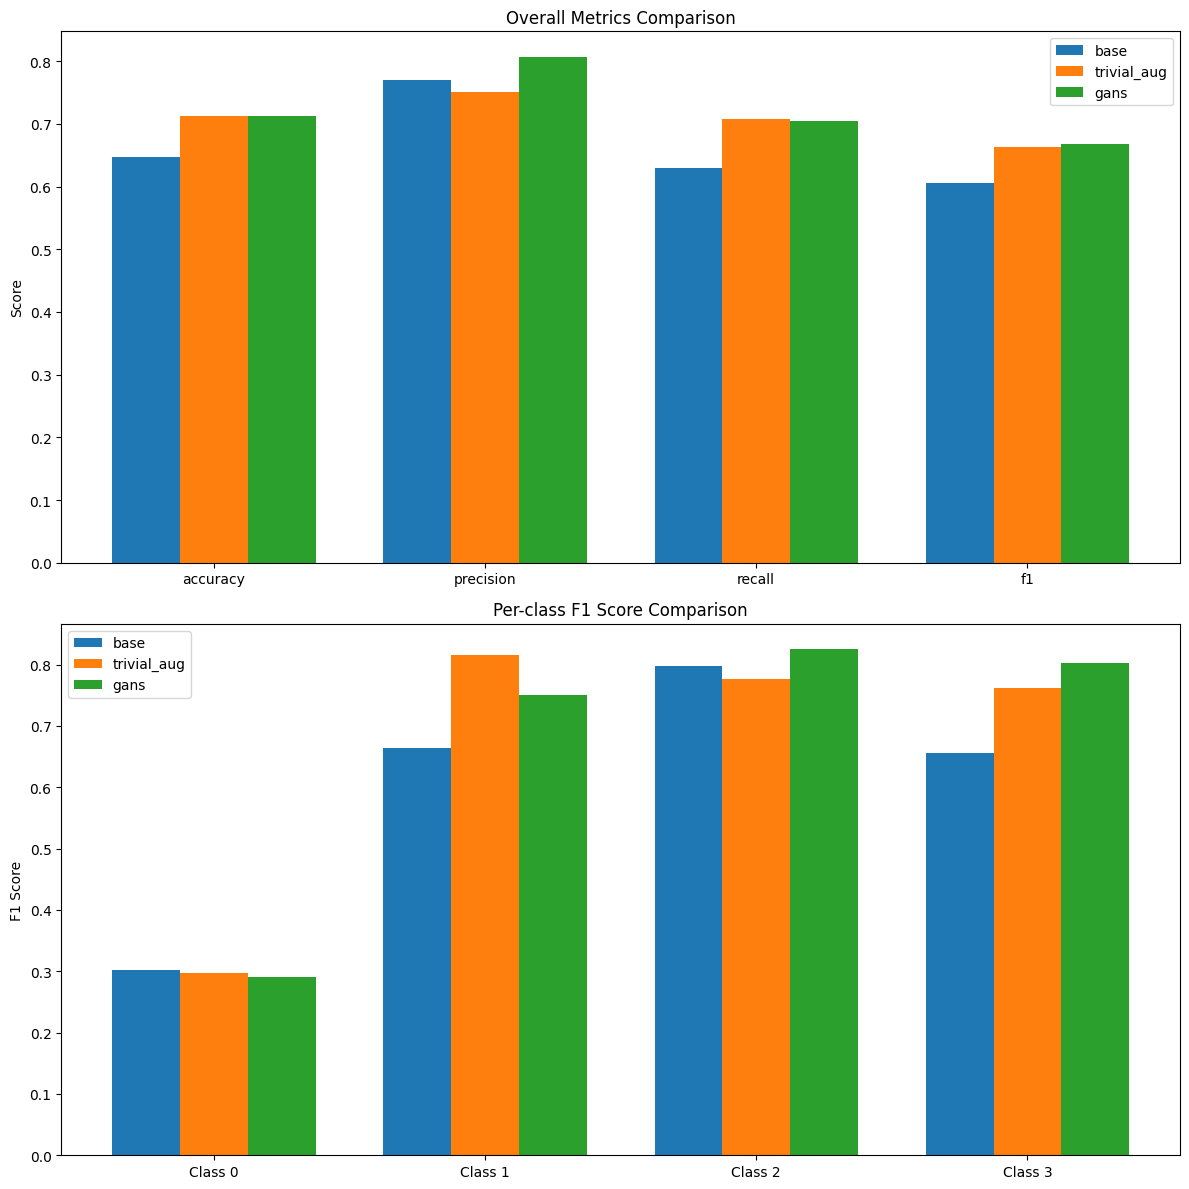

In [ ]:
# Create visualization
plot_metrics_comparison(results)

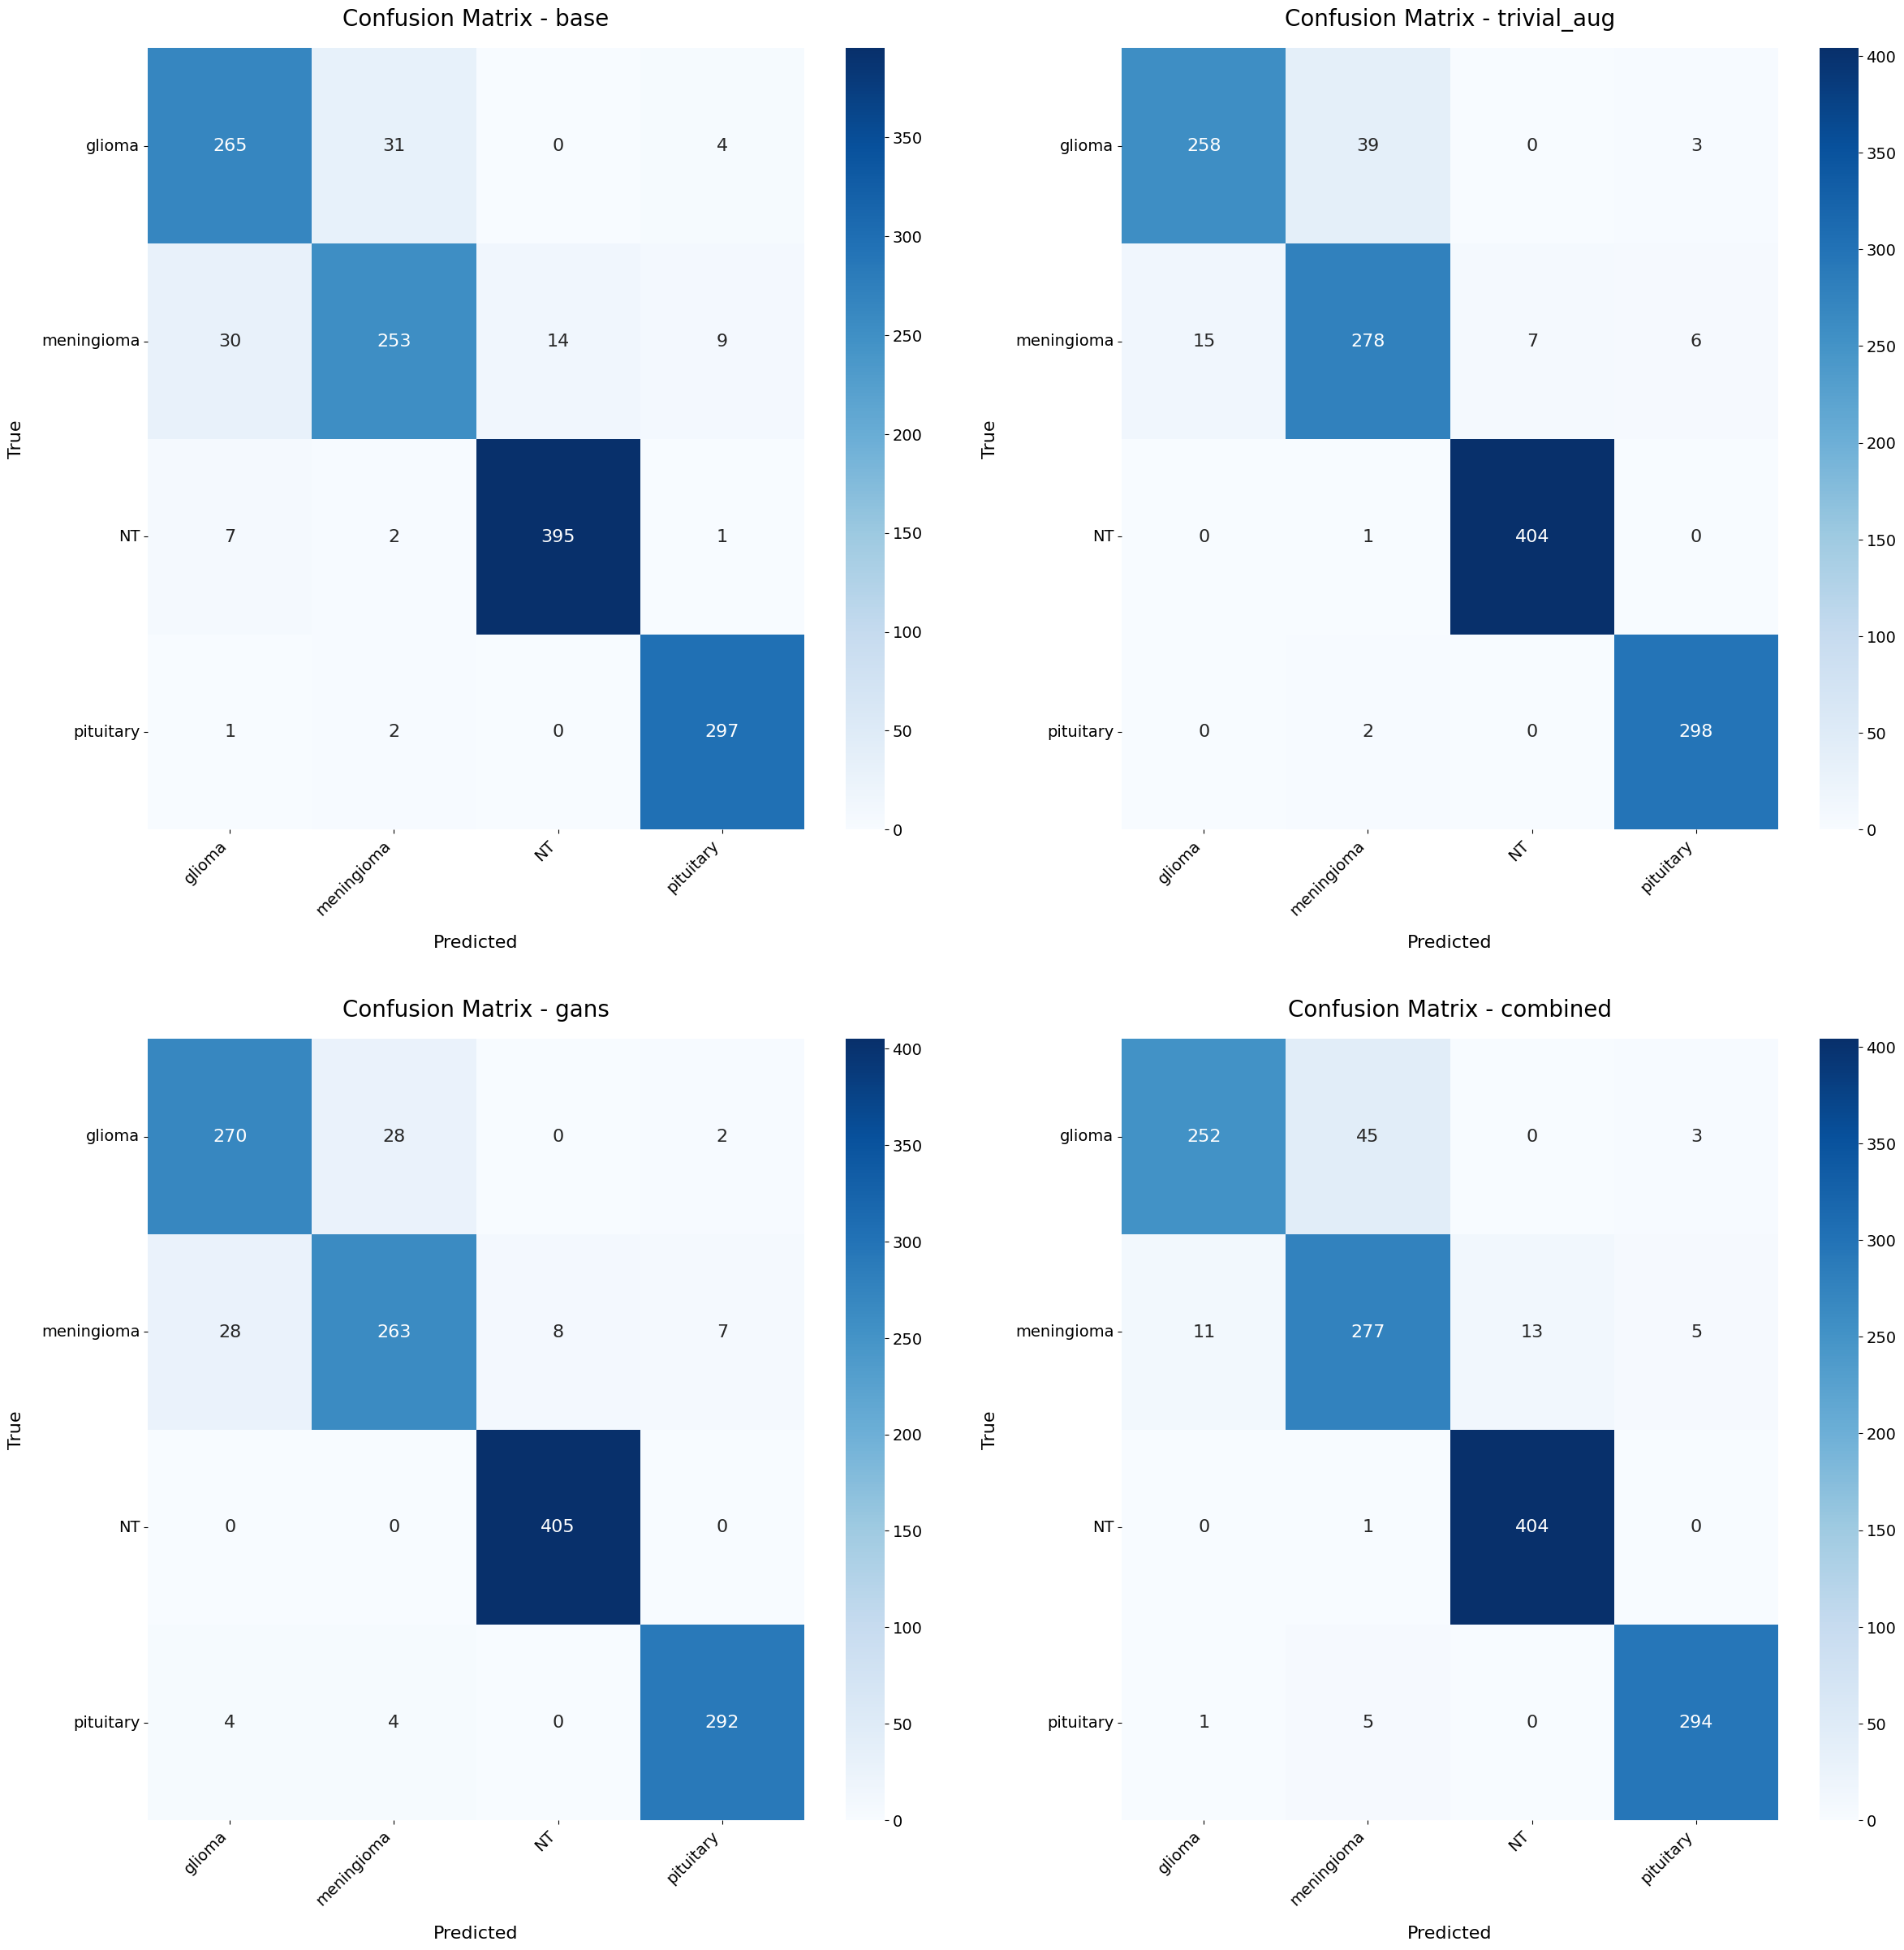

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class names
CLASS_NAMES = ['glioma', 'meningioma', 'NT', 'pituitary']

def get_model_predictions_proba(model, data_loader, device='cuda'):
    """
    Get probability predictions from model
    """
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())

    return np.array(all_probs), np.array(all_labels)

def plot_confusion_matrices(models, test_loader, device='cuda'):
    """
    Plot confusion matrices for all models with class names and larger font sizes
    """
    # Set global font sizes
    plt.rcParams.update({'font.size': 14})  # Base font size

    # Store predictions for each model
    y_trues = []
    y_preds = []

    # Get predictions for all models first
    for model in models.values():
        y_prob, y_true = get_model_predictions_proba(model, test_loader, device)
        y_pred = np.argmax(y_prob, axis=1)
        y_trues.append(y_true)
        y_preds.append(y_pred)

    fig, axes = plt.subplots(2, 2, figsize=(25, 25))
    axes = axes.ravel()

    for i, (model_name, model) in enumerate(models.items()):
        # Get predictions
        y_prob, y_true = get_model_predictions_proba(model, test_loader, device)
        y_pred = np.argmax(y_prob, axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Plot with class names and larger font
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=CLASS_NAMES,
                   yticklabels=CLASS_NAMES,
                   annot_kws={'size': 16})  # Larger annotation font

        # Increase font sizes for all elements
        axes[i].set_title(f'Confusion Matrix - {model_name}', fontsize=20, pad=20)
        axes[i].set_xlabel('Predicted', fontsize=16, labelpad=15)
        axes[i].set_ylabel('True', fontsize=16, labelpad=15)

        # Increase tick label sizes
        axes[i].tick_params(axis='both', which='major', labelsize=14)

        # Rotate x-axis labels for better readability
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
        plt.setp(axes[i].get_yticklabels(), rotation=0)

    # Add more space between subplots
    plt.tight_layout(pad=3.0)

    # Save the combined plot
    plt.savefig('drive/MyDrive/results/confusion_matrices_combined.jpg', bbox_inches='tight', dpi=300)

    # Save individual plots
    for i, model_name in enumerate(models.keys()):
        # Create a new figure for each model
        plt.figure(figsize=(12, 12))

        # Get the data from the original plot
        ax = plt.gca()
        sns.heatmap(confusion_matrix(y_trues[i], y_preds[i]),
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=CLASS_NAMES,
                   yticklabels=CLASS_NAMES,
                   annot_kws={'size': 16})

        plt.title(f'Confusion Matrix - {model_name}', fontsize=20, pad=20)
        plt.xlabel('Predicted', fontsize=16, labelpad=15)
        plt.ylabel('True', fontsize=16, labelpad=15)

        # Adjust tick parameters
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        # Save individual plot
        plt.tight_layout(pad=3.0)
        plt.savefig(f'drive/MyDrive/results/confusion_matrix_{model_name}.jpg', bbox_inches='tight', dpi=300)
        plt.close()

    plt.show()

# Generate visualizations and metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Plot confusion matrices
plot_confusion_matrices(models, test_loader, device)

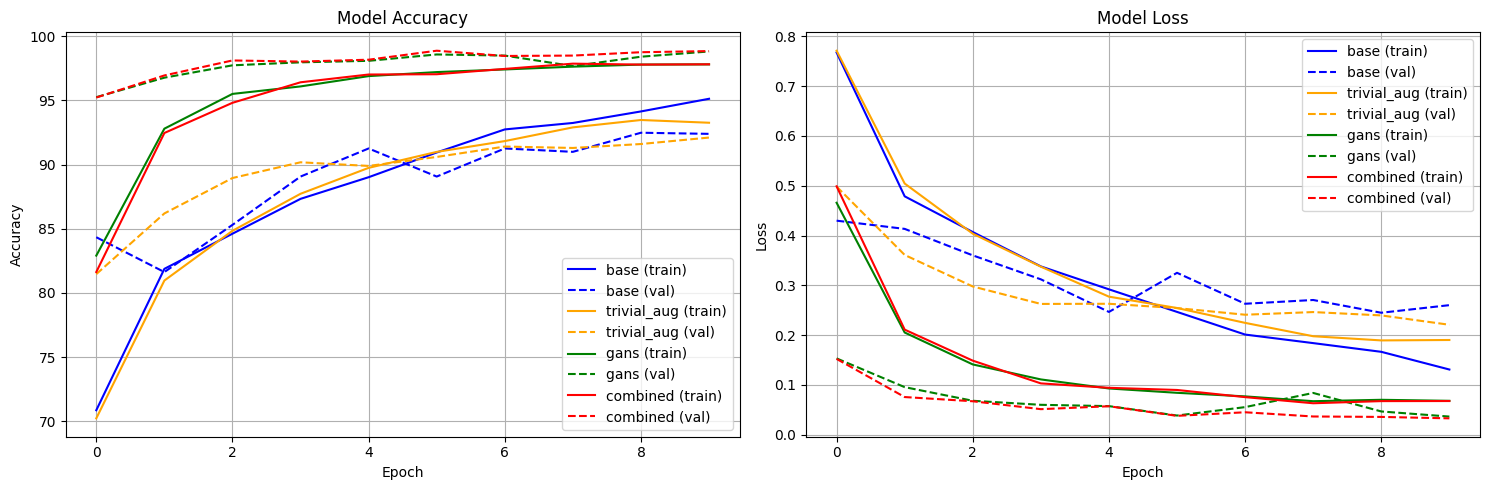

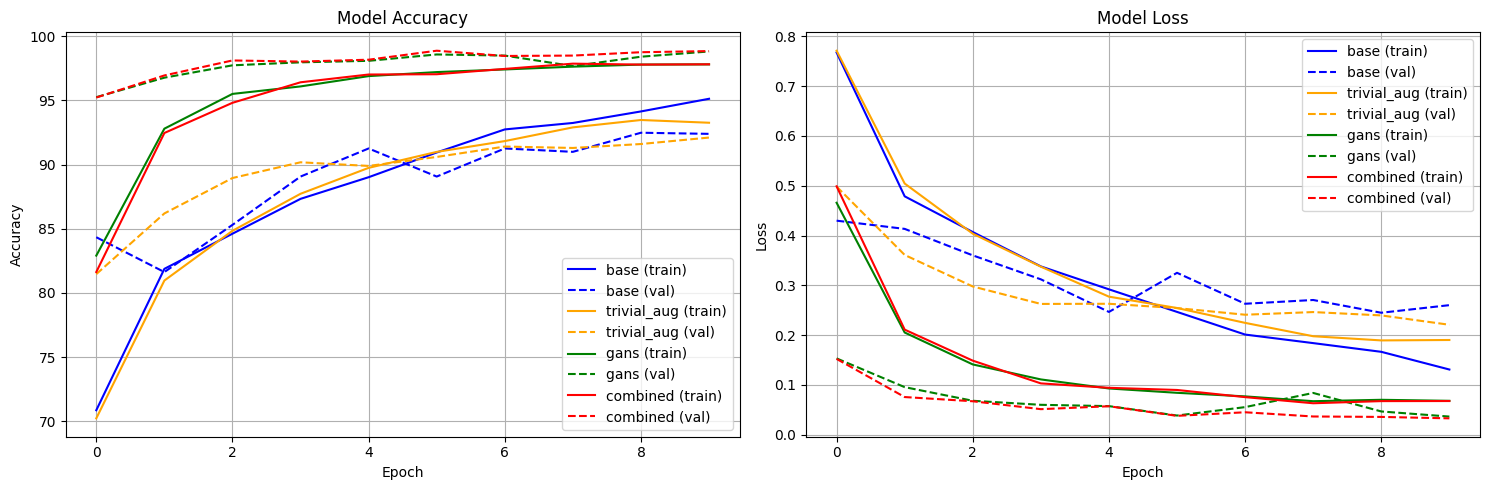

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(histories, title_suffix=""):
    """
    Plot training history for multiple models

    Args:
        histories: Dictionary with model names as keys and training histories as values
    """
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

    colors = {'base': 'blue', 'trivial_aug': 'orange', 'gans': 'green', 'combined': 'red'}
    linestyles = {'train': '-', 'val': '--'}

    for model_name, history in histories.items():
        color = colors[model_name]

        # Plot training & validation accuracy
        ax1.plot(history['train_acc'], color=color, linestyle=linestyles['train'],
                label=f'{model_name} (train)')
        ax1.plot(history['val_acc'], color=color, linestyle=linestyles['val'],
                label=f'{model_name} (val)')

        # Plot training & validation loss
        ax2.plot(history['train_loss'], color=color, linestyle=linestyles['train'],
                label=f'{model_name} (train)')
        ax2.plot(history['val_loss'], color=color, linestyle=linestyles['val'],
                label=f'{model_name} (val)')

    # Customize accuracy subplot
    ax1.set_title(f'Model Accuracy{title_suffix}')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.grid(True)
    ax1.legend(loc='lower right')

    # Customize loss subplot
    ax2.set_title(f'Model Loss{title_suffix}')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Assuming histories are stored in the checkpoint dictionaries
histories = {
    'base': histories['base'],
    'trivial_aug': histories['trivial_aug'],
    'gans': histories['gans'],
    'combined': histories['combined']
}

# Create the visualization
plot_training_history(histories)

# Create the visualization
plot_training_history(histories)

# <a id='load'>Confidence analysis::</a>

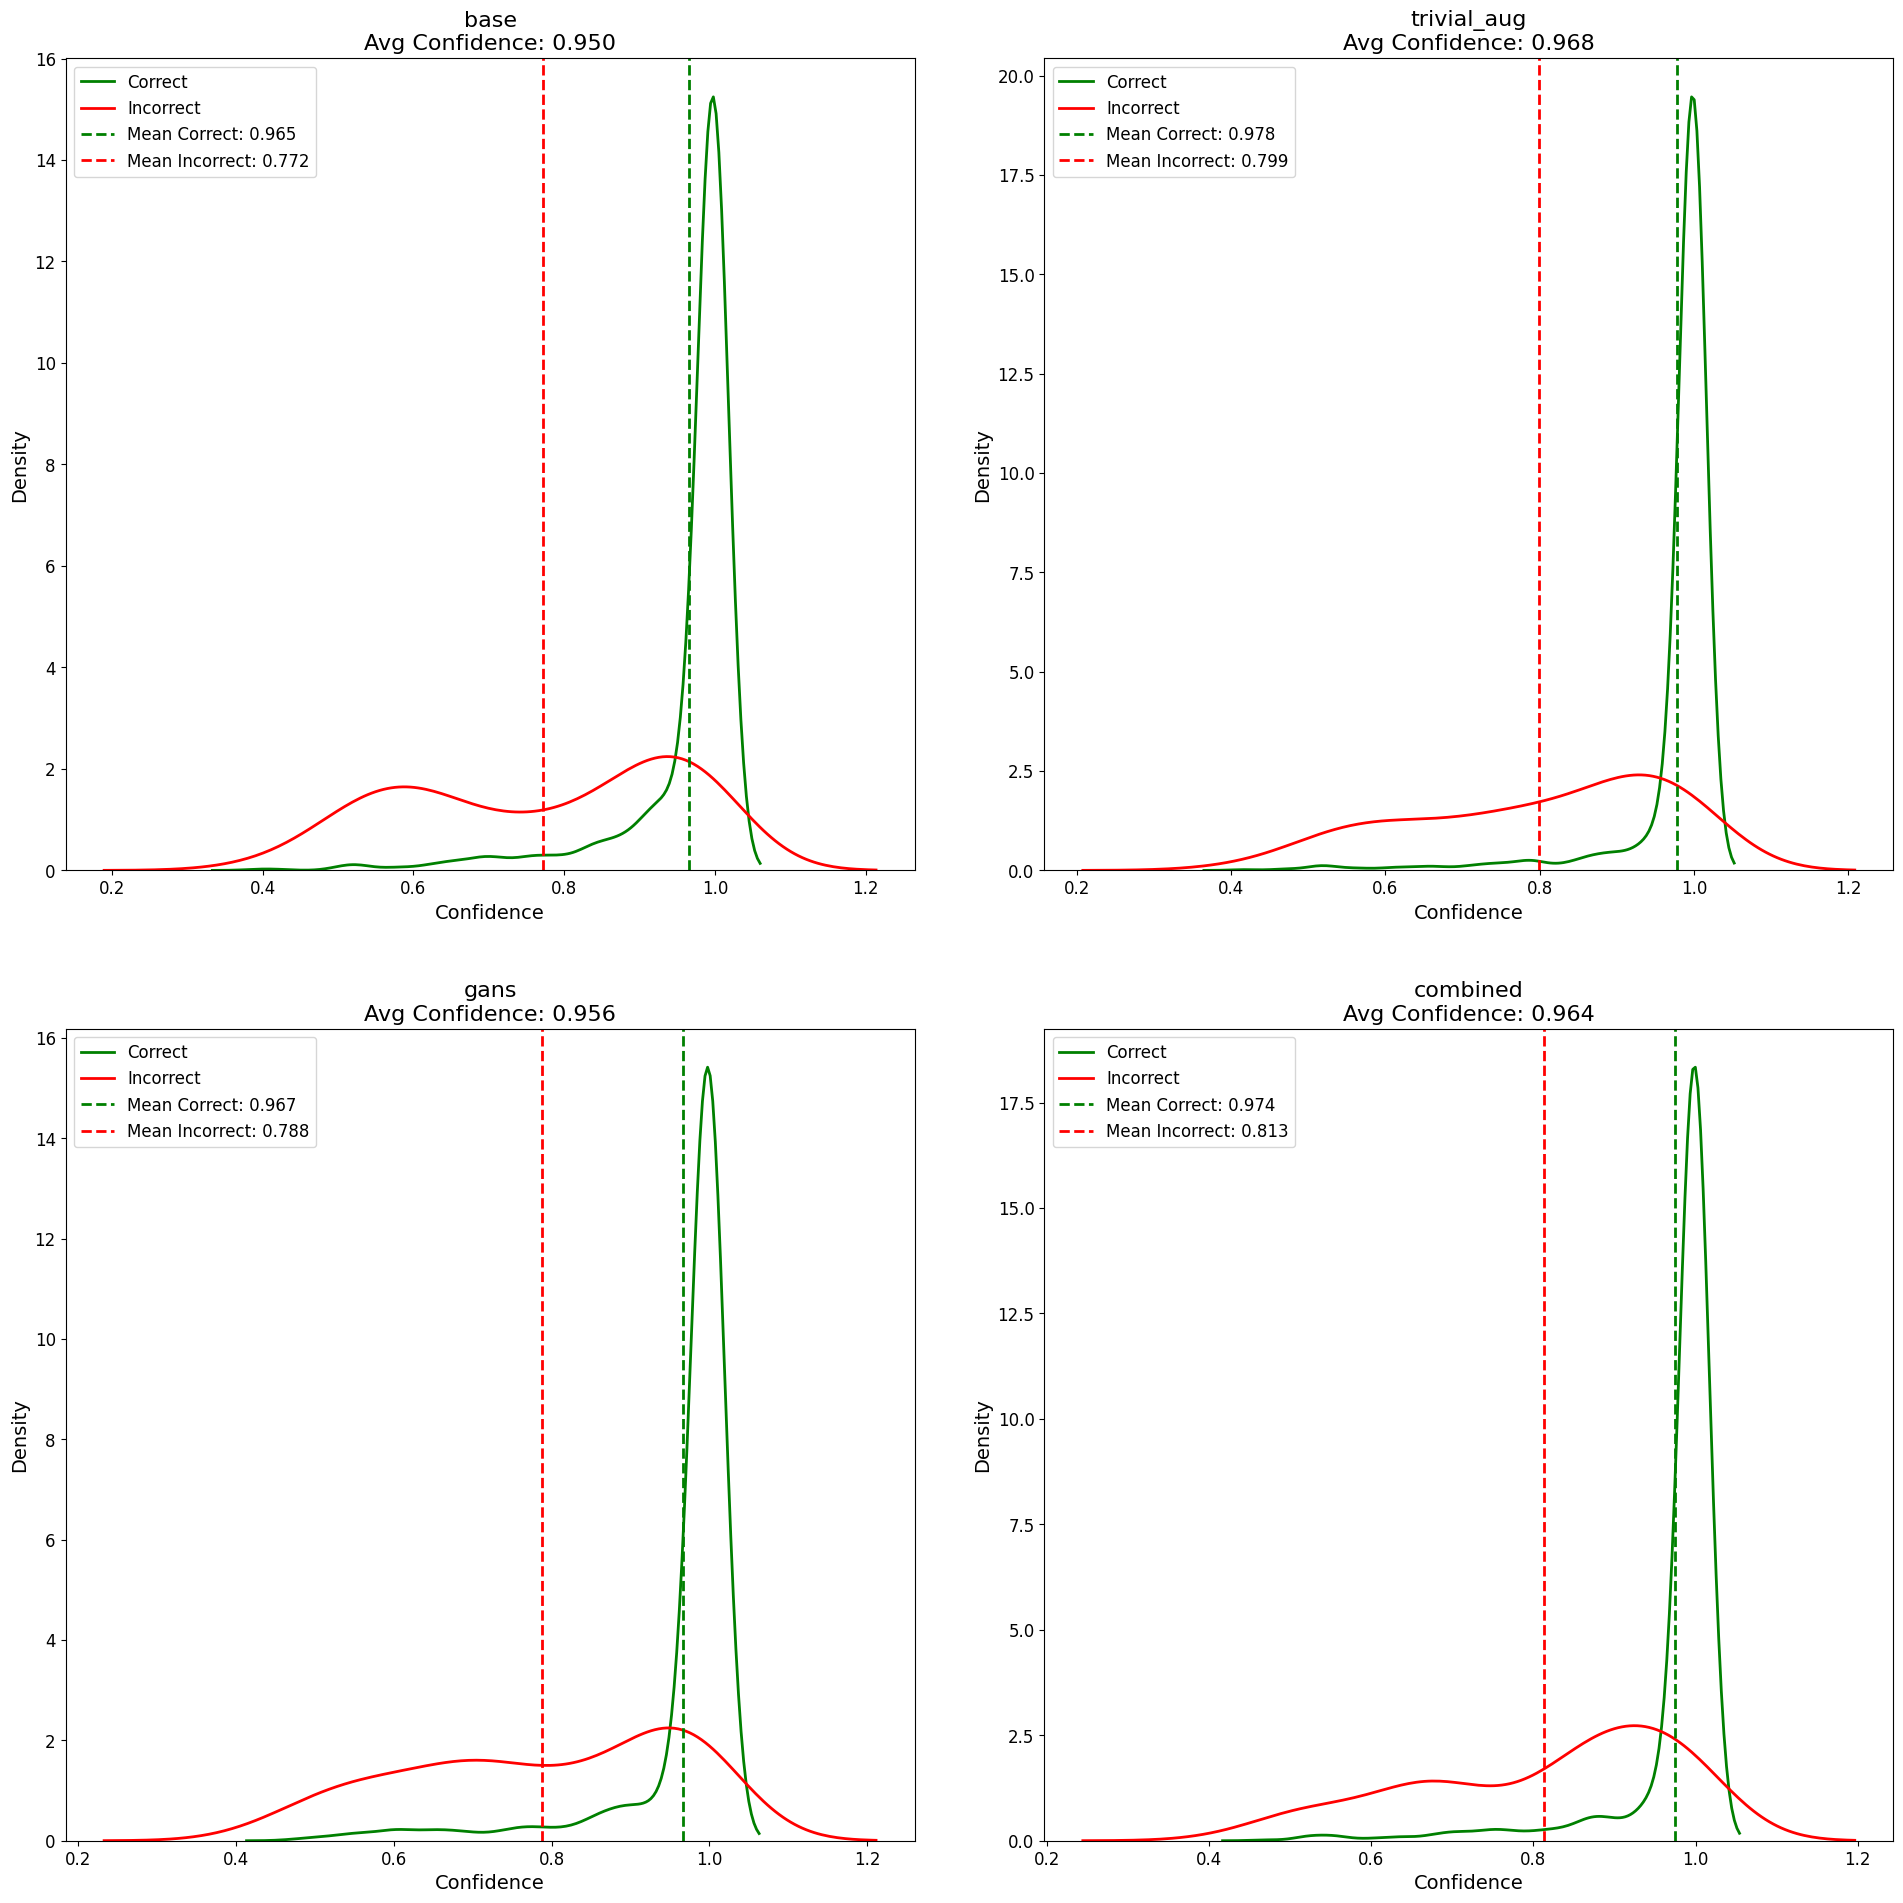


Confidence Analysis for base:
Average Confidence: 0.950
Average Confidence (Correct): 0.965
Average Confidence (Incorrect): 0.772
Accuracy for High Confidence (>0.9): 0.968
Accuracy for Low Confidence (<0.5): 0.333
Number of Overconfident Errors: 36
Number of Underconfident Correct: 2

Per-class Analysis:
glioma:
  Average Confidence: 0.931
  Accuracy: 0.883
meningioma:
  Average Confidence: 0.898
  Accuracy: 0.827
NT:
  Average Confidence: 0.979
  Accuracy: 0.975
pituitary:
  Average Confidence: 0.984
  Accuracy: 0.990

Confidence Analysis for trivial_aug:
Average Confidence: 0.968
Average Confidence (Correct): 0.978
Average Confidence (Incorrect): 0.799
Accuracy for High Confidence (>0.9): 0.976
Accuracy for Low Confidence (<0.5): 0.500
Number of Overconfident Errors: 28
Number of Underconfident Correct: 3

Per-class Analysis:
glioma:
  Average Confidence: 0.936
  Accuracy: 0.860
meningioma:
  Average Confidence: 0.936
  Accuracy: 0.908
NT:
  Average Confidence: 0.995
  Accuracy: 0.

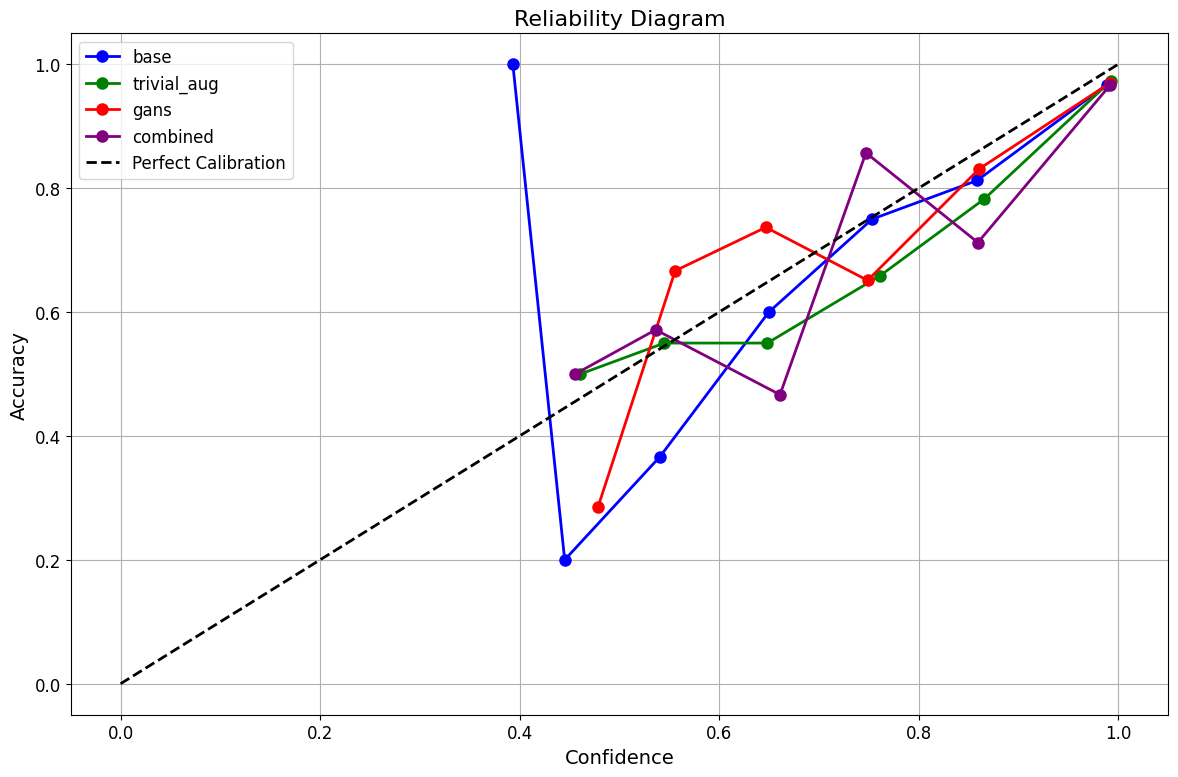

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_prediction_confidences(model, data_loader, device='cuda'):
    """
    Get prediction confidences and correctness for each sample
    """
    model.eval()
    confidences = []
    correctness = []
    pred_classes = []
    true_classes = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()

            # Get confidence and predicted class
            confidence, predictions = torch.max(torch.softmax(outputs, dim=1), dim=1)

            # Store results
            confidences.extend(confidence.cpu().numpy())
            correctness.extend((predictions.cpu() == labels).numpy())
            pred_classes.extend(predictions.cpu().numpy())
            true_classes.extend(labels.numpy())

    return np.array(confidences), np.array(correctness), np.array(pred_classes), np.array(true_classes)

def plot_confidence_distributions(models, test_loader, device='cuda'):
    """
    Plot confidence distributions for correct vs incorrect predictions
    """
    # Create a 2x2 grid for 4 models
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.ravel()

    for idx, (model_name, model) in enumerate(models.items()):
        confidences, correctness, _, _ = get_prediction_confidences(model, test_loader, device)

        # Separate confidences for correct and incorrect predictions
        correct_conf = confidences[correctness == 1]
        incorrect_conf = confidences[correctness == 0]

        # Plot distributions with larger fonts
        sns.kdeplot(data=correct_conf, ax=axes[idx], label='Correct', color='green', linewidth=2)
        sns.kdeplot(data=incorrect_conf, ax=axes[idx], label='Incorrect', color='red', linewidth=2)

        # Add statistics
        axes[idx].axvline(np.mean(correct_conf), color='green', linestyle='--',
                         label=f'Mean Correct: {np.mean(correct_conf):.3f}', linewidth=2)
        axes[idx].axvline(np.mean(incorrect_conf), color='red', linestyle='--',
                         label=f'Mean Incorrect: {np.mean(incorrect_conf):.3f}', linewidth=2)

        axes[idx].set_title(f'{model_name}\nAvg Confidence: {np.mean(confidences):.3f}', fontsize=16)
        axes[idx].set_xlabel('Confidence', fontsize=14)
        axes[idx].set_ylabel('Density', fontsize=14)
        axes[idx].tick_params(axis='both', labelsize=12)
        axes[idx].legend(fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.savefig('drive/MyDrive/confidence_distributions.jpg', bbox_inches='tight', dpi=300)
    plt.show()

def analyze_confidence_metrics(models, test_loader, device='cuda'):
    """
    Compute and print detailed confidence metrics
    """
    CLASS_NAMES = ['glioma', 'meningioma', 'NT', 'pituitary']
    results = {}

    for model_name, model in models.items():
        confidences, correctness, pred_classes, true_classes = get_prediction_confidences(
            model, test_loader, device)

        # Calculate metrics
        metrics = {
            'avg_confidence': np.mean(confidences),
            'avg_confidence_correct': np.mean(confidences[correctness == 1]),
            'avg_confidence_incorrect': np.mean(confidences[correctness == 0]),
            'high_conf_accuracy': np.mean(correctness[confidences > 0.9]),
            'low_conf_accuracy': np.mean(correctness[confidences < 0.5]),
            'overconfident_errors': np.sum((confidences > 0.9) & (correctness == 0)),
            'underconfident_correct': np.sum((confidences < 0.5) & (correctness == 1))
        }

        # Calculate per-class confidence
        for class_idx in range(4):
            class_mask = true_classes == class_idx
            metrics[f'class_{class_idx}_confidence'] = np.mean(confidences[class_mask])
            metrics[f'class_{class_idx}_accuracy'] = np.mean(correctness[class_mask])

        results[model_name] = metrics

        # Print results
        print(f"\nConfidence Analysis for {model_name}:")
        print(f"Average Confidence: {metrics['avg_confidence']:.3f}")
        print(f"Average Confidence (Correct): {metrics['avg_confidence_correct']:.3f}")
        print(f"Average Confidence (Incorrect): {metrics['avg_confidence_incorrect']:.3f}")
        print(f"Accuracy for High Confidence (>0.9): {metrics['high_conf_accuracy']:.3f}")
        print(f"Accuracy for Low Confidence (<0.5): {metrics['low_conf_accuracy']:.3f}")
        print(f"Number of Overconfident Errors: {metrics['overconfident_errors']}")
        print(f"Number of Underconfident Correct: {metrics['underconfident_correct']}")
        print("\nPer-class Analysis:")
        for i in range(4):
            print(f"{CLASS_NAMES[i]}:")
            print(f"  Average Confidence: {metrics[f'class_{i}_confidence']:.3f}")
            print(f"  Accuracy: {metrics[f'class_{i}_accuracy']:.3f}")

    return results

def plot_confidence_calibration(models, test_loader, device='cuda', n_bins=10):
    """
    Plot calibration curves for all models
    """
    plt.figure(figsize=(12, 8))

    colors = ['blue', 'green', 'red', 'purple']
    for idx, (model_name, model) in enumerate(models.items()):
        confidences, correctness, _, _ = get_prediction_confidences(model, test_loader, device)

        # Create confidence bins
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Calculate accuracy for each bin
        bin_accuracies = []
        bin_confidences = []

        for i in range(n_bins):
            mask = (confidences >= bin_edges[i]) & (confidences < bin_edges[i + 1])
            if np.sum(mask) > 0:
                bin_accuracies.append(np.mean(correctness[mask]))
                bin_confidences.append(np.mean(confidences[mask]))

        plt.plot(bin_confidences, bin_accuracies, 'o-', label=model_name,
                color=colors[idx], linewidth=2, markersize=8)

    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
    plt.xlabel('Confidence', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Reliability Diagram', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.savefig('drive/MyDrive/calibration_curves.jpg', bbox_inches='tight', dpi=300)
    plt.show()

# Run all analyses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Plot confidence distributions
plot_confidence_distributions(models, test_loader, device)

# Analyze confidence metrics
results = analyze_confidence_metrics(models, test_loader, device)

# Plot calibration curves
plot_confidence_calibration(models, test_loader, device)

# <a id='load'>confus.matrix + error rates:</a>

In [ ]:
def get_model_predictions(model, data_loader, device='cuda'):
    """
    Get predictions and true labels from a model
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrices(models, test_loader, device='cuda'):
    """
    Plot confusion matrices for all models side by side
    """
    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
    if len(models) == 1:
        axes = [axes]

    for idx, (model_name, model) in enumerate(models.items()):
        predictions, true_labels = get_model_predictions(model, test_loader, device)
        cm = confusion_matrix(true_labels, predictions)

        # Calculate percentages
        cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

        # Plot
        sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{model_name}\nConfusion Matrix (%)')
        axes[idx].set_xlabel('Predicted Class')
        axes[idx].set_ylabel('True Class')

    plt.tight_layout()
    plt.show()

def analyze_error_patterns(models, test_loader, device='cuda'):
    """
    Analyze and compare error patterns across models
    """
    results = {}

    for model_name, model in models.items():  # Fixed: removed enumerate
        predictions, true_labels = get_model_predictions(model, test_loader, device)

        # Calculate per-class metrics
        class_metrics = {}
        for class_idx in range(4):
            class_mask = true_labels == class_idx
            class_metrics[f'class_{class_idx}'] = {
                'accuracy': np.mean(predictions[class_mask] == class_idx),
                'total_samples': np.sum(class_mask),
                'misclassified_as': {}
            }

            # Analyze misclassifications
            wrong_predictions = predictions[class_mask & (predictions != class_idx)]
            for wrong_class in range(4):
                if wrong_class != class_idx:
                    count = np.sum(wrong_predictions == wrong_class)
                    class_metrics[f'class_{class_idx}']['misclassified_as'][wrong_class] = count

        results[model_name] = class_metrics

        # Print analysis
        print(f"\nError Analysis for {model_name}:")
        for class_idx in range(4):
            metrics = class_metrics[f'class_{class_idx}']
            print(f"\nClass {class_idx}:")
            print(f"Accuracy: {metrics['accuracy']:.3f}")
            print(f"Total samples: {metrics['total_samples']}")
            if metrics['misclassified_as']:
                print("Misclassification pattern:")
                for wrong_class, count in metrics['misclassified_as'].items():
                    percentage = (count / metrics['total_samples']) * 100
                    print(f"  As class {wrong_class}: {count} samples ({percentage:.1f}%)")

    return results

def plot_error_comparison(models, test_loader, device='cuda'):
    """
    Plot comparison of error rates across models
    """
    # Get error rates for each class and model
    error_data = []
    for model_name, model in models.items():
        predictions, true_labels = get_model_predictions(model, test_loader, device)
        for class_idx in range(4):
            class_mask = true_labels == class_idx
            error_rate = 1 - np.mean(predictions[class_mask] == class_idx)
            error_data.append({
                'Model': model_name,
                'Class': f'Class {class_idx}',
                'Error Rate': error_rate * 100
            })

    # Create DataFrame and plot
    df = pd.DataFrame(error_data)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Class', y='Error Rate', hue='Model')
    plt.title('Error Rates by Class and Model')
    plt.ylabel('Error Rate (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

def find_common_errors(models, test_loader, device='cuda', top_k=5):
    """
    Find and analyze samples that are commonly misclassified across models
    """
    all_predictions = {}

    # Get predictions from all models
    for model_name, model in models.items():
        predictions, true_labels = get_model_predictions(model, test_loader, device)
        all_predictions[model_name] = predictions

    # Find samples misclassified by all models
    common_errors = []
    for i in range(len(true_labels)):
        true_class = true_labels[i]
        all_wrong = all(all_predictions[model_name][i] != true_class
                       for model_name in models.keys())
        if all_wrong:
            pred_classes = {model_name: all_predictions[model_name][i]
                          for model_name in models.keys()}
            common_errors.append({
                'index': i,
                'true_class': true_class,
                'predictions': pred_classes
            })

    # Print analysis of common errors
    print(f"\nFound {len(common_errors)} samples misclassified by all models")
    if common_errors:
        print("\nTop common error patterns:")
        error_patterns = {}
        for error in common_errors:
            pattern = (error['true_class'],
                      tuple(error['predictions'].values()))
            error_patterns[pattern] = error_patterns.get(pattern, 0) + 1

        for (true_class, pred_pattern), count in sorted(
            error_patterns.items(), key=lambda x: x[1], reverse=True)[:top_k]:
            print(f"\nTrue Class: {true_class}")
            print(f"Predicted as: {dict(zip(models.keys(), pred_pattern))}")
            print(f"Occurrences: {count}")

    return common_errors

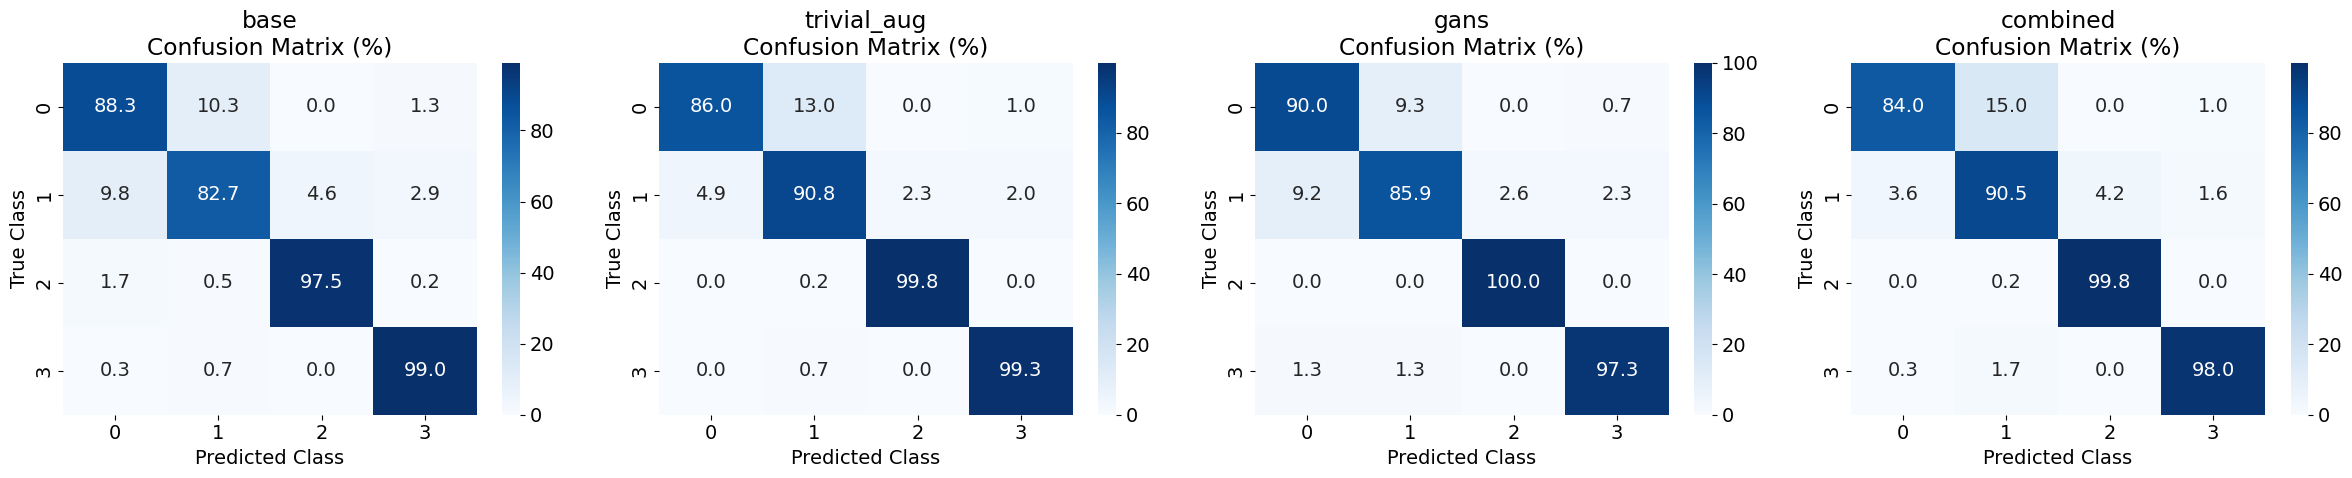

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plot_confusion_matrices(models, test_loader, device)

In [ ]:
results = analyze_error_patterns(models, test_loader, device)


Error Analysis for base:

Class 0:
Accuracy: 0.883
Total samples: 300
Misclassification pattern:
  As class 1: 31 samples (10.3%)
  As class 2: 0 samples (0.0%)
  As class 3: 4 samples (1.3%)

Class 1:
Accuracy: 0.827
Total samples: 306
Misclassification pattern:
  As class 0: 30 samples (9.8%)
  As class 2: 14 samples (4.6%)
  As class 3: 9 samples (2.9%)

Class 2:
Accuracy: 0.975
Total samples: 405
Misclassification pattern:
  As class 0: 7 samples (1.7%)
  As class 1: 2 samples (0.5%)
  As class 3: 1 samples (0.2%)

Class 3:
Accuracy: 0.990
Total samples: 300
Misclassification pattern:
  As class 0: 1 samples (0.3%)
  As class 1: 2 samples (0.7%)
  As class 2: 0 samples (0.0%)

Error Analysis for trivial_aug:

Class 0:
Accuracy: 0.860
Total samples: 300
Misclassification pattern:
  As class 1: 39 samples (13.0%)
  As class 2: 0 samples (0.0%)
  As class 3: 3 samples (1.0%)

Class 1:
Accuracy: 0.908
Total samples: 306
Misclassification pattern:
  As class 0: 15 samples (4.9%)
  As c

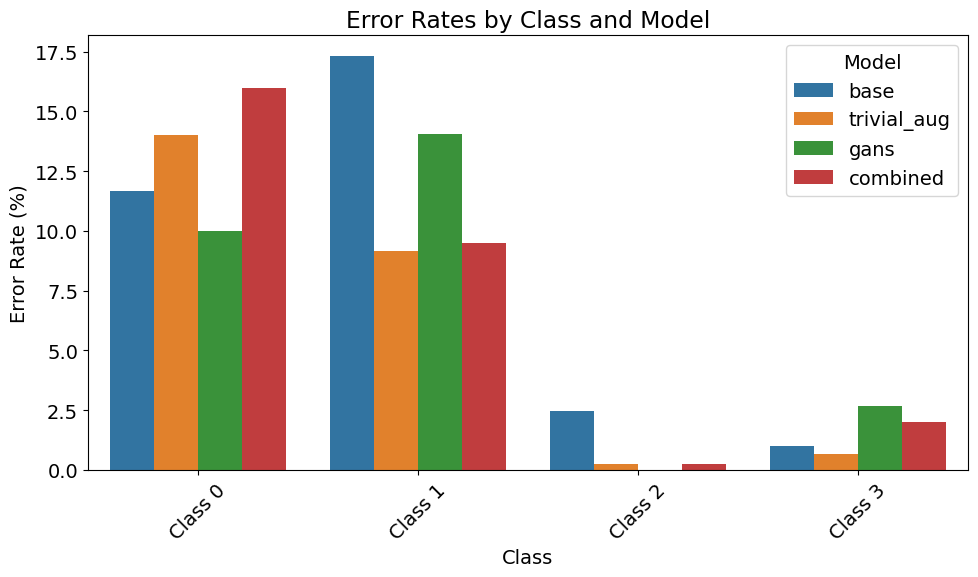

In [ ]:
plot_error_comparison(models, test_loader, device)